# Imports

In [ ]:
# !pip install torch
# !pip install nibabel
# !pip PIL
# !pip install numpy
# !pip install torchio
# !pip install torchsummary

In [ ]:
import nibabel as nb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sys
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
import math
import pickle

# Connect with google **drive**

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/test/oluvil/updated data'

/content/drive/MyDrive/test/oluvil/updated data


## Training

In [ ]:
images = np.load('target/training/numpy/images.npy')
masks = np.load('target/training/numpy/masks.npy')

## Testing

In [ ]:
images_testing = np.load('target/testing/numpy/images.npy')
masks_testing = np.load('target/testing/numpy/masks.npy')

## Validation

In [ ]:
images_validation = np.load('target/validation/numpy/images.npy')
masks_validation = np.load('target/validation/numpy/masks.npy')

____________________________

# Transforms

In [ ]:
def replace_tensor_value_(tensor):
    return tensor

input_transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

targets_transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

# Hyperparams

In [ ]:
import torch

learning_rate = 0.0001
batch_size = 2
num_epochs = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The current processor is ...', device)

The current processor is ... cpu


# Data Loaders

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None, target_transform=None):
      self.data = data
      self.targets = targets
      self.transform = transform
      self.target_transform = target_transform


    def __getitem__(self, index):
      x = self.data[index]
      y = self.targets[index]

      if self.transform:
        # x = self.data[index]  # remove
        x = self.transform(x)

      if self.target_transform:
        # y = self.targets[index] # remove
        y = self.target_transform(y)

      return x, y

    def __len__(self):
      return len(self.data)


# Create datasets
train_dataset = MyDataset(images, masks, transform=input_transform, target_transform=targets_transform)
del images # Deletes Images and Mask for freeup the RAM
del masks

test_dataset = MyDataset(images_testing, masks_testing, transform=input_transform, target_transform=targets_transform)
del images_testing # Deletes images_testing and masks_testing for freeup the RAM
del masks_testing

val_dataset = MyDataset(images_validation, masks_validation, transform=input_transform, target_transform=targets_transform)
del images_validation # Deletes images_validation and masks_validation for freeup the RAM
del masks_validation


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size)
del train_dataset

test_loader = DataLoader(test_dataset, batch_size=batch_size)
del test_dataset

val_loader = DataLoader(val_dataset, batch_size=batch_size)
del val_dataset

In [ ]:
inputs, classes = next(iter(train_loader))
inputs.shape, inputs.min(), inputs.max(), classes.shape, classes.min(), classes.max()

(torch.Size([2, 3, 512, 512]),
 tensor(0.),
 tensor(0.9765),
 torch.Size([2, 1, 512, 512]),
 tensor(0.),
 tensor(1.))

# Plot Image

img shape: (512, 512, 3) dtype: float32 min: 0.0 max: 0.9764706
mask shape: (1, 512, 512) dtype: float32 min: 0.0 max: 1.0


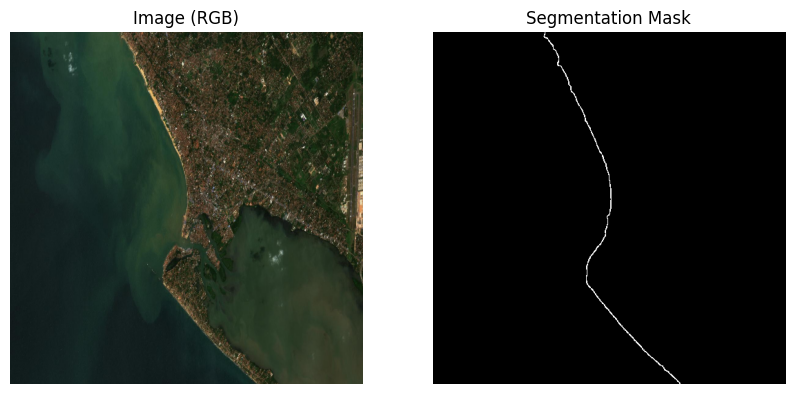

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_images(img, mask):
    print("img shape:", img.shape, "dtype:", img.dtype, "min:", img.min(), "max:", img.max())
    print("mask shape:", mask.shape, "dtype:", mask.dtype, "min:", mask.min(), "max:", mask.max())

    # Ensure mask is in the correct shape (H, W)
    if len(mask.shape) == 3 and mask.shape[0] == 1:
        mask = mask.squeeze(0)  # Remove channel dimension

    # Normalize mask to 0-255 if necessary
    if mask.max() <= 1.0:
        mask = (mask * 255).astype(np.uint8)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display RGB image
    axs[0].imshow(img)
    axs[0].set_title("Image (RGB)")
    axs[0].axis("off")

    # Display mask in grayscale
    axs[1].imshow(mask, cmap='gray', vmin=0, vmax=255)
    axs[1].set_title("Segmentation Mask")
    axs[1].axis("off")

    plt.show()

# Example Usage:
plot_images(inputs[0].cpu().numpy().transpose(1, 2, 0), classes[0].cpu().numpy())


img shape: (512, 512, 3) dtype: float32 min: 0.0 max: 0.9764706
mask shape: (1, 512, 512) dtype: float32 min: 0.0 max: 1.0


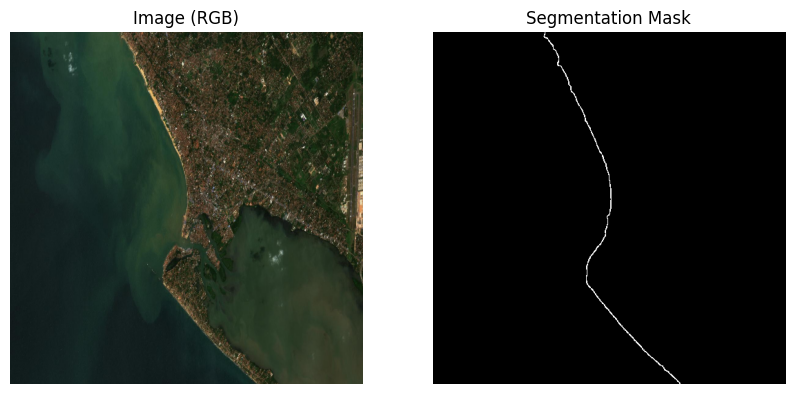

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_images(img, mask):
    print("img shape:", img.shape, "dtype:", img.dtype, "min:", img.min(), "max:", img.max())
    print("mask shape:", mask.shape, "dtype:", mask.dtype, "min:", mask.min(), "max:", mask.max())

    # Ensure mask is in the correct shape
    if len(mask.shape) == 3 and mask.shape[0] == 1:
        mask = mask.squeeze(0)  # Remove channel dimension if it's (1, H, W)

    # Normalize mask to 0-255 if necessary
    if mask.max() <= 1.0:
        mask = (mask * 255).astype(np.uint8)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display RGB image
    axs[0].imshow(img)
    axs[0].set_title("Image (RGB)")
    axs[0].axis("off")

    # Display mask in grayscale
    axs[1].imshow(mask, cmap='gray', vmin=0, vmax=255)
    axs[1].set_title("Segmentation Mask")
    axs[1].axis("off")

    plt.show()

# Example usage:
# Convert image to numpy and transpose the channels for the RGB format
plot_images(inputs[0].numpy().transpose(1, 2, 0), classes[0].numpy())


# Loss Function

## Dice Score

In [ ]:
import torch
from torch import Tensor

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

## Hausdorff distance

In [ ]:
def hausdorff_distance(tensor1, tensor2):
    tensor1_flat = tensor1.reshape(tensor1.shape[0], -1)  # Flatten spatial dimensions
    tensor2_flat = tensor2.reshape(tensor2.shape[0], -1)

    distances = torch.cdist(tensor1_flat, tensor2_flat)

    shortest_distance_1to2, _ = torch.min(distances, dim=1)
    shortest_distance_2to1, _ = torch.min(distances, dim=0)

    return torch.max(shortest_distance_1to2.max(), shortest_distance_2to1.max())

def hd_loss(mask_pred, mask_true):
    batch_size = mask_pred.size(0)
    num_classes = mask_pred.size(1)  # Number of classes # todo

    hd_loss_per_sample = []

    for batch_idx in range(batch_size):
        hd_per_class = []
        for class_idx in range(num_classes):
            dist = hausdorff_distance(mask_pred[batch_idx, class_idx].cpu(), mask_true[batch_idx, class_idx].cpu())
            hd_per_class.append(dist)
        hd_loss_per_sample.append(torch.mean(torch.stack(hd_per_class)))

    return torch.mean(torch.stack(hd_loss_per_sample))



# UNet Model

In [ ]:
# import torch
# import torch.nn as nn

# class UNet2D(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UNet2D, self).__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels

#         # Encoder blocks
#         self.encoder1 = self.double_conv(in_channels, 64)
#         self.pool1 = nn.MaxPool2d(2)
#         self.encoder2 = self.double_conv(64, 128)
#         self.pool2 = nn.MaxPool2d(2)
#         self.encoder3 = self.double_conv(128, 256)
#         self.pool3 = nn.MaxPool2d(2)
#         self.encoder4 = self.double_conv(256, 512)
#         self.pool4 = nn.MaxPool2d(2)

#         # Middle block
#         self.middle = self.double_conv(512, 1024)

#         # Decoder blocks
#         self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
#         self.decoder1 = self.double_conv(1024, 512)
#         self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.decoder2 = self.double_conv(512, 256)
#         self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.decoder3 = self.double_conv(256, 128)
#         self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.decoder4 = self.double_conv(128, 64)

#         # Output layer
#         self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

#     def forward(self, x):
#         # Encoder
#         enc1 = self.encoder1(x)
#         enc1_pool = self.pool1(enc1)

#         enc2 = self.encoder2(enc1_pool)
#         enc2_pool = self.pool2(enc2)

#         enc3 = self.encoder3(enc2_pool)
#         enc3_pool = self.pool3(enc3)

#         enc4 = self.encoder4(enc3_pool)
#         enc4_pool = self.pool4(enc4)

#         # Middle
#         middle = self.middle(enc4_pool)

#         print(enc4.shape)

#         # check
#         dec1 = self.up1(middle) # Define dec1 here before using it

#         diffY = enc4.size()[2] - dec1.size()[2]
#         diffX = enc4.size()[3] - dec1.size()[3]

#         dec1 = F.pad(dec1, [diffX // 2, diffX - diffX // 2,
#                             diffY // 2, diffY - diffY // 2])

#         dec1 = torch.cat([enc4, dec1], dim=1)
#         dec1 = self.decoder1(dec1)

#         # # Decoder
#         # dec1 = self.up1(middle)
#         # dec1 = torch.cat([enc4, dec1], dim=1)
#         # dec1 = self.decoder1(dec1)

#         dec2 = self.up2(dec1)
#         dec2 = torch.cat([enc3, dec2], dim=1)
#         dec2 = self.decoder2(dec2)

#         dec3 = self.up3(dec2)
#         dec3 = torch.cat([enc2, dec3], dim=1)
#         dec3 = self.decoder3(dec3)

#         dec4 = self.up4(dec3)
#         dec4 = torch.cat([enc1, dec4], dim=1)
#         dec4 = self.decoder4(dec4)

#         # Output
#         output = self.out_conv(dec4)
#         return output

#     def double_conv(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class UNet2D(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UNet2D, self).__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels

#         # Encoder blocks
#         self.encoder1 = self.double_conv(in_channels, 64)
#         self.pool1 = nn.MaxPool2d(2)
#         self.encoder2 = self.double_conv(64, 128)
#         self.pool2 = nn.MaxPool2d(2)
#         self.encoder3 = self.double_conv(128, 256)
#         self.pool3 = nn.MaxPool2d(2)
#         self.encoder4 = self.double_conv(256, 512)
#         self.pool4 = nn.MaxPool2d(2)

#         # Middle block
#         self.middle = self.double_conv(512, 1024)

#         # Decoder blocks
#         self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
#         self.decoder1 = self.double_conv(1024, 512)
#         self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.decoder2 = self.double_conv(512, 256)
#         self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.decoder3 = self.double_conv(256, 128)
#         self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.decoder4 = self.double_conv(128, 64)

#         # Output layer
#         self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

#     def forward(self, x):
#         # Encoder
#         enc1 = self.encoder1(x)
#         enc1_pool = self.pool1(enc1)

#         enc2 = self.encoder2(enc1_pool)
#         enc2_pool = self.pool2(enc2)

#         enc3 = self.encoder3(enc2_pool)
#         enc3_pool = self.pool3(enc3)

#         enc4 = self.encoder4(enc3_pool)
#         enc4_pool = self.pool4(enc4)

#         # Middle
#         middle = self.middle(enc4_pool)

#         # Decoder with padding before concatenation
#         dec1 = self.up1(middle)
#         dec1 = self.pad_tensor(dec1, enc4)  # Match size before concatenation
#         dec1 = torch.cat([enc4, dec1], dim=1)
#         dec1 = self.decoder1(dec1)

#         dec2 = self.up2(dec1)
#         dec2 = self.pad_tensor(dec2, enc3)
#         dec2 = torch.cat([enc3, dec2], dim=1)
#         dec2 = self.decoder2(dec2)

#         dec3 = self.up3(dec2)
#         dec3 = self.pad_tensor(dec3, enc2)
#         dec3 = torch.cat([enc2, dec3], dim=1)
#         dec3 = self.decoder3(dec3)

#         dec4 = self.up4(dec3)
#         dec4 = self.pad_tensor(dec4, enc1)
#         dec4 = torch.cat([enc1, dec4], dim=1)
#         dec4 = self.decoder4(dec4)

#         # Output
#         output = self.out_conv(dec4)
#         return output

#     def double_conv(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def pad_tensor(self, small, large):
#         """Pads 'small' tensor to match the spatial size of 'large' tensor"""
#         diffY = large.size()[2] - small.size()[2]
#         diffX = large.size()[3] - small.size()[3]

#         small = F.pad(small, [diffX // 2, diffX - diffX // 2,
#                               diffY // 2, diffY - diffY // 2])
#         return small


In [ ]:
import torch
import torch.nn as nn

class UNet2D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Encoder blocks
        self.encoder1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Middle block
        self.middle = self.double_conv(512, 1024)

        # Decoder blocks
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder1 = self.double_conv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder2 = self.double_conv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = self.double_conv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder4 = self.double_conv(128, 64)

        # Output block
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc1_pool = self.pool1(enc1)

        enc2 = self.encoder2(enc1_pool)
        enc2_pool = self.pool2(enc2)

        enc3 = self.encoder3(enc2_pool)
        enc3_pool = self.pool3(enc3)

        enc4 = self.encoder4(enc3_pool)
        enc4_pool = self.pool4(enc4)

        # Middle
        middle = self.middle(enc4_pool)

        # Decoder
        dec1 = self.up1(middle)
        dec1 = torch.cat([enc4, dec1], dim=1)
        dec1 = self.decoder1(dec1)

        dec2 = self.up2(dec1)
        dec2 = torch.cat([enc3, dec2], dim=1)
        dec2 = self.decoder2(dec2)

        dec3 = self.up3(dec2)
        dec3 = torch.cat([enc2, dec3], dim=1)
        dec3 = self.decoder3(dec3)

        dec4 = self.up4(dec3)
        dec4 = torch.cat([enc1, dec4], dim=1)
        dec4 = self.decoder4(dec4)

        # Output
        output = self.out_conv(dec4)
        return output

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )


# Training

In [ ]:
in_channels = 3
out_channels = 2
model = UNet2D(in_channels, out_channels).to(device)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F

# Define optimizer (AdamW is generally better)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Cosine Annealing Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Enable Mixed Precision Training
grad_scaler = torch.cuda.amp.GradScaler(enabled=True)  # Enable for better performance

# Loss function (CrossEntropy for multi-class segmentation)
# criterion = nn.CrossEntropyLoss() # todo clip the output values



<ipython-input-20-d4a71952c397>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler(enabled=True)  # Enable for better performance
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
inputs, classes = next(iter(train_loader))
inputs.shape, inputs.min(), inputs.max(), classes.shape, classes.min(), classes.max()

(torch.Size([2, 3, 512, 512]),
 tensor(0.),
 tensor(0.9765),
 torch.Size([2, 1, 512, 512]),
 tensor(0.),
 tensor(1.))

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
for index, (inputs, classes) in enumerate(train_loader):
  test_out = model(inputs.to(device))
  classes_1 = classes.to(dtype=torch.long).to(device).squeeze(1)

  masks_one_hot = torch.nn.functional.one_hot(classes_1, num_classes=model.out_channels).permute(0, 3, 1, 2).float()
  criterion = F.binary_cross_entropy_with_logits(test_out, masks_one_hot)
  print(criterion)
  break

tensor(0.6256, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [ ]:

test_out = model(inputs.to(device))

classes_1 = classes.to(dtype=torch.long).to(device).squeeze(1)

masks_one_hot = torch.nn.functional.one_hot(classes_1, num_classes=model.out_channels).permute(0, 3, 1, 2).float()

criterion = F.binary_cross_entropy_with_logits(test_out, masks_one_hot)



In [ ]:
# from torch.optim.lr_scheduler import StepLR

# # Use a StepLR scheduler to decrease the learning rate at fixed intervals
# scheduler = StepLR(optimizer, step_size=10, gamma=0.5)  # Decay rate can be adjusted


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from torchsummary import summary
model = model.to("cuda")  # Move model to GPU
summary(model, input_size=(3, 512 , 512))  # Ensure correct input size


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# training_data = {"Loss_vals":[], "accuracy_vals":[], "hd_vals":[],"lr_decay":[]}
training_data = {"loss":[], "epoch":[],"lr":[], "dice_loss":[], "hd_loss":[], "multiclass_dice_score": []}
model_path = '../final_model/vanila_unet_512/la-batch-size-2-CosineAnnealingLR-prelu-200-epoch-base-unet-without-prelu'
model.train()

In [ ]:
import pickle
import os
import math
import torch.nn.functional as F
from tqdm import tqdm  # Import tqdm for progress bars

num_epochs = 150
min_loss = math.inf  # Initialize the best loss tracking

# Ensure the directory exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Initialize the training_data dictionary before training starts
training_data = {
    "loss": [],
    "epoch": [],
    "lr": [],
    "dice_score": [],
}

for epoch in range(num_epochs):
    total_loss = 0
    epoch_dice_score = 0

    # Use tqdm to track batch progress
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        for index, (inputs, classes) in enumerate(train_loader):
            # Move inputs and targets to GPU
            inputs = inputs.to(dtype=torch.float).to(device)
            classes_1 = classes.to(dtype=torch.long).to(device).squeeze(1)

            # Forward pass
            test_out = model(inputs)

            # One-hot encode ground truth masks
            masks_one_hot = torch.nn.functional.one_hot(classes_1, num_classes=model.out_channels).permute(0, 3, 1, 2).float()

            # Compute loss using BCE with logits
            loss = F.binary_cross_entropy_with_logits(test_out, masks_one_hot)

            # Compute Dice score
            with torch.no_grad():
                dice_score = multiclass_dice_coeff(test_out, masks_one_hot, reduce_batch_first=False)

            # Update loss trackers
            total_loss += loss.item()
            epoch_dice_score += dice_score.item()

            # Backward pass
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            # Update tqdm progress bar
            pbar.set_postfix(loss=loss.item(), dice_score=dice_score.item())
            pbar.update(1)

    # Compute epoch metrics
    epoch_loss = total_loss / len(train_loader)
    epoch_dice_score = epoch_dice_score / len(train_loader)

    # Update learning rate scheduler
    scheduler.step()

    # Log training data
    training_data["loss"].append(epoch_loss)
    training_data["epoch"].append(epoch)
    training_data["lr"].append(optimizer.param_groups[0]['lr'])
    training_data["dice_score"].append(epoch_dice_score)

    # Print metrics for the current epoch
    # print(f"Epoch {epoch + 1}: Loss={epoch_loss:.4f}, Dice Score={epoch_dice_score:.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")

    # Save best model if current epoch loss is less than min_loss
    if epoch_loss < min_loss:
        # Save the model state_dict
        torch.save(model.state_dict(), f'{model_path}.pt')

        # Save the training data (metrics)
        with open(f'{model_path}.pkl', 'wb') as f:
            pickle.dump(training_data, f)

        # Update the minimum loss
        min_loss = epoch_loss


Epoch 150/150: 100%|██████████| 134/134 [01:07<00:00,  1.99batch/s, dice_score=0.947, loss=0.00106]


In [ ]:
# import pickle
# import os
# import math
# import torch.nn.functional as F

# num_epochs = 200
# min_loss = math.inf  # Initialize the best loss tracking

# # Ensure the directory exists
# os.makedirs(os.path.dirname(model_path), exist_ok=True)

# # Initialize the training_data dictionary before training starts
# training_data = {
#     "loss": [],
#     "epoch": [],
#     "lr": [],
#     "dice_score": [],  # Ensure this key is initialized to avoid KeyError
# }

# for epoch in range(num_epochs):
#     total_loss = 0
#     epoch_dice_score = 0

#     for index, (inputs, classes) in enumerate(train_loader):
#         # Move inputs and targets to GPU
#         inputs = inputs.to(dtype=torch.float).to(device)
#         classes_1 = classes.to(dtype=torch.long).to(device).squeeze(1)

#         # Forward pass
#         test_out = model(inputs)

#         # One-hot encode ground truth masks
#         masks_one_hot = torch.nn.functional.one_hot(classes_1, num_classes=model.out_channels).permute(0, 3, 1, 2).float()

#         # Compute loss using BCE with logits
#         loss = F.binary_cross_entropy_with_logits(test_out, masks_one_hot)

#         # Compute Dice score
#         with torch.no_grad():
#             dice_score = multiclass_dice_coeff(test_out, masks_one_hot, reduce_batch_first=False)

#         # Update loss trackers
#         total_loss += loss.item()
#         epoch_dice_score += dice_score.item()

#         # Backward pass
#         optimizer.zero_grad(set_to_none=True)
#         loss.backward()
#         optimizer.step()

#     # Compute epoch metrics
#     epoch_loss = total_loss / len(train_loader)
#     epoch_dice_score = epoch_dice_score / len(train_loader)

#     # Update learning rate scheduler
#     scheduler.step()

#     # Log training data
#     training_data["loss"].append(epoch_loss)
#     training_data["epoch"].append(epoch)
#     training_data["lr"].append(optimizer.param_groups[0]['lr'])
#     training_data["dice_score"].append(epoch_dice_score)  # Now this key will not cause KeyError

#     # Print metrics for the current epoch
#     print(f"Epoch {epoch + 1}: Loss={epoch_loss:.4f}, Dice Score={epoch_dice_score:.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")

#     # Save best model if current epoch loss is less than min_loss
#     if epoch_loss < min_loss:
#         # Save the model state_dict
#         torch.save(model.state_dict(), f'{model_path}.pt')

#         # Save the training data (metrics)
#         with open(f'{model_path}.pkl', 'wb') as f:
#             pickle.dump(training_data, f)

#         # Update the minimum loss
#         min_loss = epoch_loss


In [ ]:
# num_epochs = 200

# import pickle  # Make sure to import pickle for saving data
# import os

# min_loss = math.inf  # Initialize the best loss tracking

# # Ensure the directory exists
# os.makedirs(os.path.dirname(model_path), exist_ok=True)

# for epoch in range(num_epochs):
#     total_loss = 0
#     dice_loss_val = 0
#     hd_loss_val = 0
#     dice_score_val = 0
#     epoch_hd = 0  # To store total HD loss for epoch
#     epoch_dice_loss = 0  # To store total Dice loss for epoch

#     for index, (inputs, classes) in enumerate(train_loader):
#         # Move inputs and targets to GPU
#         inputs = inputs.to(dtype=torch.float).to(device)
#         classes_1 = classes.to(dtype=torch.long).to(device).squeeze(1)  # No need for one-hot encoding

#         # Forward pass
#         pred_mask = model(inputs)  # No softmax needed

#         # Convert prediction to class labels
#         pred = torch.argmax(pred_mask[0], dim=0).cpu().detach()

#         # One-hot encode masks if necessary
#         masks_one_hot = torch.nn.functional.one_hot(classes_1, num_classes=model.out_channels).permute(0, 3, 1, 2).float()

#         # Compute losses
#         mean_dice_loss = dice_loss(pred_mask, masks_one_hot, multiclass=True)
#         mean_hd_loss = hd_loss(pred_mask, masks_one_hot)

#         # Compute lambda parameter safely
#         if epoch == 0:
#             lambda_param = mean_hd_loss / (mean_dice_loss + 1e-8)
#         else:
#             lambda_param = epoch_hd / (epoch_dice_loss + 1e-8)

#         loss = lambda_param * mean_dice_loss + mean_hd_loss

#         # Compute dice score
#         with torch.no_grad():
#             dice_score = multiclass_dice_coeff(pred_mask, masks_one_hot, reduce_batch_first=False)

#         # Update loss trackers
#         total_loss += loss.item()
#         dice_loss_val += mean_dice_loss.item()
#         hd_loss_val += mean_hd_loss.item()
#         dice_score_val += dice_score.item()

#         # Backward pass
#         optimizer.zero_grad(set_to_none=True)
#         grad_scaler.scale(loss).backward()
#         grad_scaler.step(optimizer)
#         grad_scaler.update()

#     # Compute epoch metrics
#     epoch_loss = total_loss / len(train_loader)
#     epoch_dice_loss = dice_loss_val / len(train_loader)
#     epoch_dice_score = dice_score_val / len(train_loader)
#     epoch_hd = hd_loss_val / len(train_loader)

#     # Update learning rate scheduler
#     scheduler.step()

#     # Log training data
#     training_data["loss"].append(epoch_loss)
#     training_data["epoch"].append(epoch)
#     training_data["lr"].append(optimizer.param_groups[0]['lr'])
#     training_data["dice_loss"].append(epoch_dice_loss)
#     training_data["hd_loss"].append(epoch_hd)
#     training_data["multiclass_dice_score"].append(epoch_dice_score)

#     # Print metrics for the current epoch
#     print(f"Epoch {epoch + 1}: Loss={epoch_loss:.4f}, Dice Loss={epoch_dice_loss:.4f}, HD Loss={epoch_hd:.4f}, Dice Score={epoch_dice_score:.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")

#     # Save best model if current epoch loss is less than min_loss
#     if epoch_loss < min_loss:
#         # Save the model state_dict
#         torch.save(model.state_dict(), f'{model_path}.pt')

#         # Save the training data (metrics)
#         with open(f'{model_path}.pkl', 'wb') as f:
#             pickle.dump(training_data, f)

#         # Update the minimum loss
#         min_loss = epoch_loss


In [ ]:
# import math
# import os

# min_loss = math.inf

# # Ensure the directory exists
# os.makedirs(os.path.dirname(model_path), exist_ok=True)

# for epoch in range(num_epochs):
#     total_loss = 0
#     dice_loss_val = 0
#     hd_loss_val = 0
#     dice_score_val = 0

#     for index, (inputs, classes) in enumerate(train_loader):
#         # Move inputs and targets to GPU
#         inputs = inputs.to(dtype=torch.float).to(device)
#         classes_1 = classes.to(dtype=torch.long).to(device).squeeze(1)  # No need for one-hot encoding

#         # Forward pass
#         pred_mask = model(inputs)  # No softmax needed

#         # Convert prediction to class labels
#         pred = torch.argmax(pred_mask[0], dim=0).cpu().detach()

#         # One-hot encode masks if necessary
#         masks_one_hot = torch.nn.functional.one_hot(classes_1, num_classes=model.out_channels).permute(0, 3, 1, 2).float()

#         # Compute losses
#         mean_dice_loss = dice_loss(pred_mask, masks_one_hot, multiclass=True)
#         mean_hd_loss = hd_loss(pred_mask, masks_one_hot)

#         # Compute lambda parameter safely
#         lambda_param = (mean_hd_loss / (mean_dice_loss + 1e-8)) if epoch == 0 else (epoch_hd / (epoch_dice_loss + 1e-8))
#         loss = lambda_param * mean_dice_loss + mean_hd_loss

#         # Compute dice score
#         with torch.no_grad():
#             dice_score = multiclass_dice_coeff(pred_mask, masks_one_hot, reduce_batch_first=False)

#         # Update loss trackers
#         total_loss += loss.item()
#         dice_loss_val += mean_dice_loss.item()
#         hd_loss_val += mean_hd_loss.item()
#         dice_score_val += dice_score.item()

#         # Backward pass
#         optimizer.zero_grad(set_to_none=True)
#         grad_scaler.scale(loss).backward()
#         grad_scaler.step(optimizer)
#         grad_scaler.update()

#     # Compute epoch metrics
#     epoch_loss = total_loss / len(train_loader)
#     epoch_dice_loss = dice_loss_val / len(train_loader)
#     epoch_dice_score = dice_score_val / len(train_loader)
#     epoch_hd = hd_loss_val / len(train_loader)

#     # Update learning rate
#     scheduler.step()

#     # Log training data
#     training_data["loss"].append(epoch_loss)
#     training_data["epoch"].append(epoch)
#     training_data["lr"].append(optimizer.param_groups[0]['lr'])
#     training_data["dice_loss"].append(epoch_dice_loss)
#     training_data["hd_loss"].append(epoch_hd)
#     training_data["multiclass_dice_score"].append(epoch_dice_score)

#     # Print metrics
#     print(f"Epoch {epoch + 1}: Loss={epoch_loss:.4f}, Dice Loss={epoch_dice_loss:.4f}, HD Loss={epoch_hd:.4f}, Dice Score={epoch_dice_score:.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")

#     # Save best model
#     if epoch_loss < min_loss:
#         torch.save(model.state_dict(), f'{model_path}.pt')
#         with open(f'{model_path}.pkl', 'wb') as f:
#             pickle.dump(training_data, f)
#         min_loss = epoch_loss



In [ ]:
# import math
# import os
# import torch
# import pickle
# from torch.optim.lr_scheduler import StepLR

# # Early stopping parameters
# patience = 5  # Number of epochs to wait before early stopping
# epochs_without_improvement = 0
# min_loss = math.inf

# # Ensure the directory exists
# os.makedirs(os.path.dirname(model_path), exist_ok=True)

# # Learning rate scheduler
# scheduler = StepLR(optimizer, step_size=10, gamma=0.5)  # Decay the learning rate every 10 epochs

# for epoch in range(num_epochs):
#     total_loss = 0
#     dice_loss_val = 0
#     hd_loss_val = 0
#     dice_score_val = 0

#     for index, (inputs, classes) in enumerate(train_loader):
#         # Move inputs and targets to GPU
#         inputs = inputs.to(dtype=torch.float).to(device)
#         classes_1 = classes.to(dtype=torch.long).to(device).squeeze(1)  # No need for one-hot encoding

#         # Forward pass
#         pred_mask = model(inputs)  # No softmax needed

#         # Convert prediction to class labels
#         pred = torch.argmax(pred_mask[0], dim=0).cpu().detach()

#         # One-hot encode masks if necessary
#         masks_one_hot = torch.nn.functional.one_hot(classes_1, num_classes=model.out_channels).permute(0, 3, 1, 2).float()

#         # Compute losses
#         mean_dice_loss = dice_loss(pred_mask, masks_one_hot, multiclass=True)
#         mean_hd_loss = hd_loss(pred_mask, masks_one_hot)

#         # Compute lambda parameter safely
#         lambda_param = (mean_hd_loss / (mean_dice_loss + 1e-8)) if epoch == 0 else (epoch_hd / (epoch_dice_loss + 1e-8))
#         loss = lambda_param * mean_dice_loss + mean_hd_loss

#         # Compute dice score
#         with torch.no_grad():
#             dice_score = multiclass_dice_coeff(pred_mask, masks_one_hot, reduce_batch_first=False)

#         # Update loss trackers
#         total_loss += loss.item()
#         dice_loss_val += mean_dice_loss.item()
#         hd_loss_val += mean_hd_loss.item()
#         dice_score_val += dice_score.item()

#         # Backward pass
#         optimizer.zero_grad(set_to_none=True)
#         grad_scaler.scale(loss).backward()
#         grad_scaler.step(optimizer)
#         grad_scaler.update()

#     # Compute epoch metrics
#     epoch_loss = total_loss / len(train_loader)
#     epoch_dice_loss = dice_loss_val / len(train_loader)
#     epoch_dice_score = dice_score_val / len(train_loader)
#     epoch_hd = hd_loss_val / len(train_loader)

#     # Update learning rate
#     scheduler.step()

#     # Log training data
#     training_data["loss"].append(epoch_loss)
#     training_data["epoch"].append(epoch)
#     training_data["lr"].append(optimizer.param_groups[0]['lr'])
#     training_data["dice_loss"].append(epoch_dice_loss)
#     training_data["hd_loss"].append(epoch_hd)
#     training_data["multiclass_dice_score"].append(epoch_dice_score)

#     # Print metrics
#     print(f"Epoch {epoch + 1}: Loss={epoch_loss:.4f}, Dice Loss={epoch_dice_loss:.4f}, HD Loss={epoch_hd:.4f}, Dice Score={epoch_dice_score:.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")

#     # Early stopping: Check if the current epoch's loss is the best
#     if epoch_loss < min_loss:
#         torch.save(model.state_dict(), f'{model_path}.pt')
#         with open(f'{model_path}.pkl', 'wb') as f:
#             pickle.dump(training_data, f)
#         min_loss = epoch_loss
#         epochs_without_improvement = 0  # Reset counter for early stopping
#     else:
#         epochs_without_improvement += 1

#     # If no improvement for 'patience' epochs, stop training
#     if epochs_without_improvement >= patience:
#         print(f"Early stopping after epoch {epoch + 1}.")
#         break



In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_images(img, mask):
#     # Convert torch tensor to numpy array if it's a tensor
#     if isinstance(mask, torch.Tensor):
#         mask = mask.cpu().numpy()  # Convert to numpy array

#     # Normalize mask to 0-255 if necessary
#     if mask.max() <= 1.0:
#         mask = (mask * 255).astype(np.uint8)

#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#     axs[0].imshow(img, cmap='gray')
#     axs[0].set_title('Predicted Mask')
#     axs[1].imshow(mask, cmap='gray')
#     axs[1].set_title('True Mask')
#     plt.show()


In [ ]:
# # Plot example segmentation result
# plot_images(torch.argmax(pred, dim=0), torch.argmax(masks_one_hot[0], dim=0))

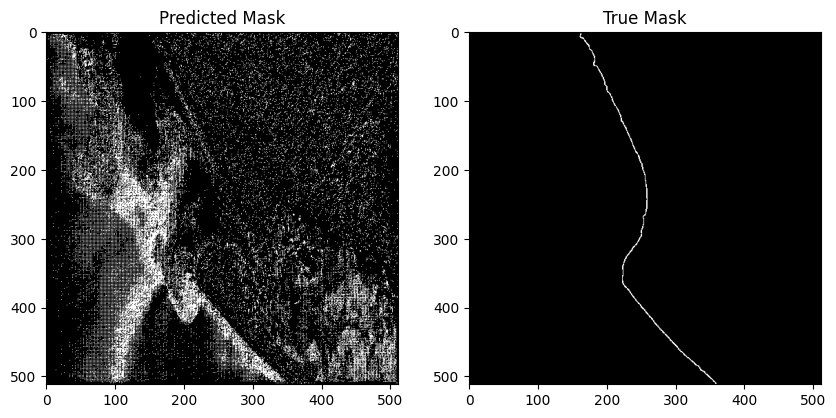

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch  # Ensure torch is imported

def plot_images(img, mask):
    # Convert torch tensor to numpy array if it's a tensor
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()  # Convert to numpy array

    # Normalize mask to 0-255 if necessary
    if mask.max() <= 1.0:
        mask = (mask * 255).astype(np.uint8)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Predicted Mask')
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('True Mask')
    plt.show()

# Get the predicted and true mask from test_out and masks_one_hot
plot_images(torch.argmax(test_out[0], dim=0).cpu(), torch.argmax(masks_one_hot[0], dim=0).cpu())


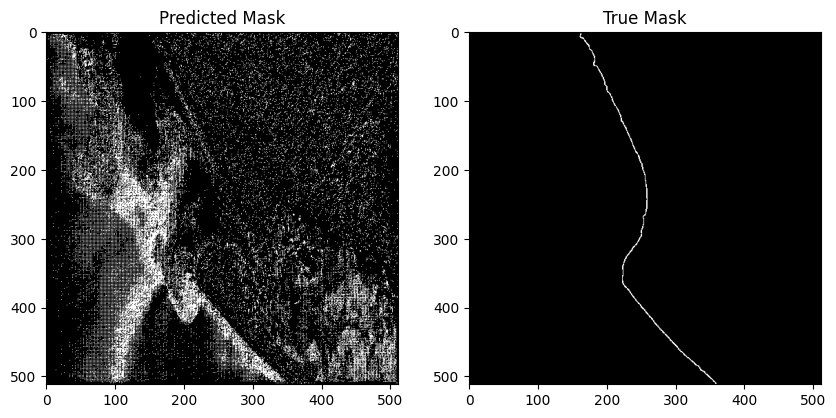

In [ ]:
for index, (inputs, classes) in enumerate(train_loader):
    inputs = inputs.to(device)  # Move input to device
    test_out = model(inputs)  # Get predictions from the model

    # Convert the predicted logits to class labels
    pred = torch.argmax(test_out, dim=1)  # Assuming multi-class segmentation

    # Prepare ground truth mask
    classes_1 = classes.to(dtype=torch.long).to(device).squeeze(1)
    masks_one_hot = torch.nn.functional.one_hot(classes_1, num_classes=model.out_channels).permute(0, 3, 1, 2).float()

    # Convert the first image's mask to plot
    plot_images(pred[0].cpu().detach(), torch.argmax(masks_one_hot[0], dim=0).cpu().detach())

    break  # Only visualize for the first batch


Pred unique values: [  0 255]
True mask unique values: [  0 255]
Pred shape: (2, 512, 512) True mask shape: (512, 512)


TypeError: Invalid shape (2, 512, 512) for image data

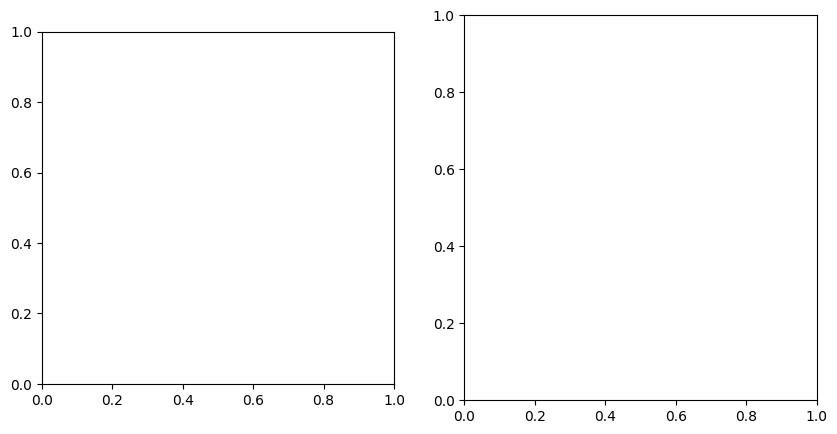

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_images(pred, true_mask):
    # Convert tensors to numpy arrays
    if isinstance(pred, torch.Tensor):
        pred = pred.cpu().detach().numpy()
    if isinstance(true_mask, torch.Tensor):
        true_mask = true_mask.cpu().detach().numpy()

    # Ensure binary format (0 and 255)
    pred = (pred > 0.5).astype(np.uint8) * 255  # Thresholding to binary
    true_mask = (true_mask > 0.5).astype(np.uint8) * 255

    # Ensure correct shape
    if pred.ndim == 3 and pred.shape[0] == 1:  # If (1, H, W), remove channel
        pred = pred.squeeze(0)
    if true_mask.ndim == 3 and true_mask.shape[0] == 1:
        true_mask = true_mask.squeeze(0)

    # Debugging: Check unique values and shapes
    print("Pred unique values:", np.unique(pred))
    print("True mask unique values:", np.unique(true_mask))
    print("Pred shape:", pred.shape, "True mask shape:", true_mask.shape)

    # Plot images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(pred, cmap='gray', vmin=0, vmax=255)
    axs[0].set_title('Predicted Mask')
    axs[0].axis('off')

    axs[1].imshow(true_mask, cmap='gray', vmin=0, vmax=255)
    axs[1].set_title('True Mask')
    axs[1].axis('off')

    plt.show()

# Example usage
pred = pred.squeeze(0)  # Remove batch dimension if present
true_mask = torch.argmax(masks_one_hot[0], dim=0)  # Convert one-hot to class index

plot_images(pred, true_mask)


In [ ]:
with open(f'{model_path}.pkl', 'wb') as f:
    pickle.dump(training_data, f)


## Test the model with one batch

In [ ]:
inputs, classes = next(iter(train_loader))
inputs.shape, inputs.min(), inputs.max(), classes.shape, classes.min(), classes.max()

In [ ]:
#forward p
optimizer.zero_grad()
pred_mask = model(inputs.to(dtype=torch.float).to(device))

In [ ]:
pred_mask = F.softmax(pred_mask, dim=1).float()

In [ ]:
pred_mask.shape

In [ ]:
pred = np.argmax(pred_mask[0].cpu().detach().numpy(), axis=0)
pred.shape

In [ ]:
classes_1 = classes.to(dtype=torch.long).to(device).squeeze(1)
print('shape of classes_1: ',classes_1.shape)
masks_one_hot = F.one_hot(classes_1, model.out_channels).permute(0, 3, 1, 2).to(dtype=torch.float)
print('shape of masks_one_hot: ',masks_one_hot.shape)

# mean_dice_loss = dice_loss(pred_mask,  masks_one_hot, multiclass=True)
# mean_hd_loss = hd_loss(pred_mask,  masks_one_hot)
# lambda_param = (mean_dice_loss/ mean_hd_loss)
# loss = mean_dice_loss + lambda_param * mean_hd_loss
# print("loss: ", loss.item())

In [ ]:
mask_ohe = np.argmax(masks_one_hot[0].cpu().detach().numpy(), axis=0)
mask_ohe.shape

In [ ]:
plot_images(pred,classes_1[0].to(dtype=torch.float).cpu())

In [ ]:
#backward p
optimizer.zero_grad(set_to_none=True)
loss.backward()
optimizer.step()

In [ ]:
# Save the model to a file
# torch.save(model.state_dict(), f'{model_path}.pt')
# with open(f'{model_path}.pkl', 'wb') as f:
#     pickle.dump(training_data, f)

model_path = '../final_model/vanila_unet_512/la-batch-size-2-CosineAnnealingLR-prelu-200-epoch-base-unet-without-prelu'
# Later, you can load the model from the file
model = UNet2D(3,2).to(device)
# model.load_state_dict(torch.load(f'{model_path}.pt'))

model.load_state_dict(torch.load(f'{model_path}.pt', map_location=torch.device('cpu')))
with open(f'{model_path}.pkl', 'rb') as filehandle:
    loaded_training_data  = pickle.load(filehandle)

<ipython-input-30-53f53aad3136>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_path}.pt', map_location=torch.device('cpu')))


In [ ]:
# for i in range(len(loaded_training_data['epoch'])):
#   print(f"({loaded_training_data['epoch'][i]})")

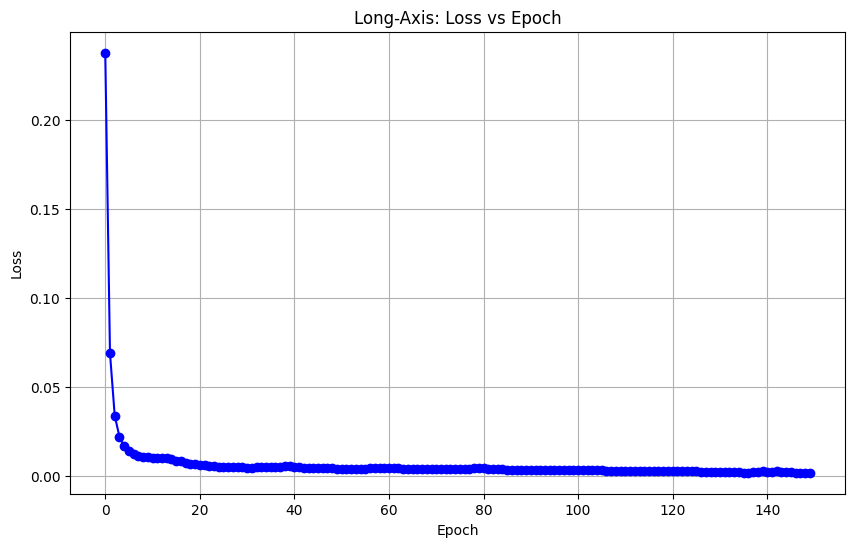

In [ ]:
import matplotlib.pyplot as plt

epoch = loaded_training_data['epoch']
loss = loaded_training_data['loss']
# dice_loss = loaded_training_data['dice_loss']
# hd_loss = loaded_training_data['hd_loss']

# plot epoch vs loss
plt.figure(figsize=(10, 6))
plt.plot(epoch, loss, marker='o', linestyle='-', color='b')
plt.title('Long-Axis: Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
# # plot epoch vs hd loss
# plt.figure(figsize=(10, 6))
# plt.plot(epoch, hd_loss, marker='o', linestyle='-', color='b')
# plt.title('Long-Axis: HD Loss vs Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.show()



In [ ]:
# # plot epoch vs dice loss
# plt.figure(figsize=(10, 6))
# plt.plot(epoch, dice_loss, marker='o', linestyle='-', color='b')
# plt.title('Long-Axis: Dice Loss vs Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.show()

# Evaluate

In [ ]:
model.eval()

# Display Predicted Image

In [ ]:
import torch

model_path = '../final_model/vanila_unet_512/la-batch-size-2-CosineAnnealingLR-prelu-200-epoch-base-unet-without-prelu'

# Define the model architecture (must match the saved model)
model = UNet2D(3,2).to(device)  # Replace with your actual model class

# Load the trained weights
model.load_state_dict(torch.load(f"{model_path}.pt", map_location="cpu"))
model.eval()  # Set to evaluation mode


<ipython-input-32-8a18a9be9d88>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_path}.pt", map_location="cpu"))


UNet2D(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

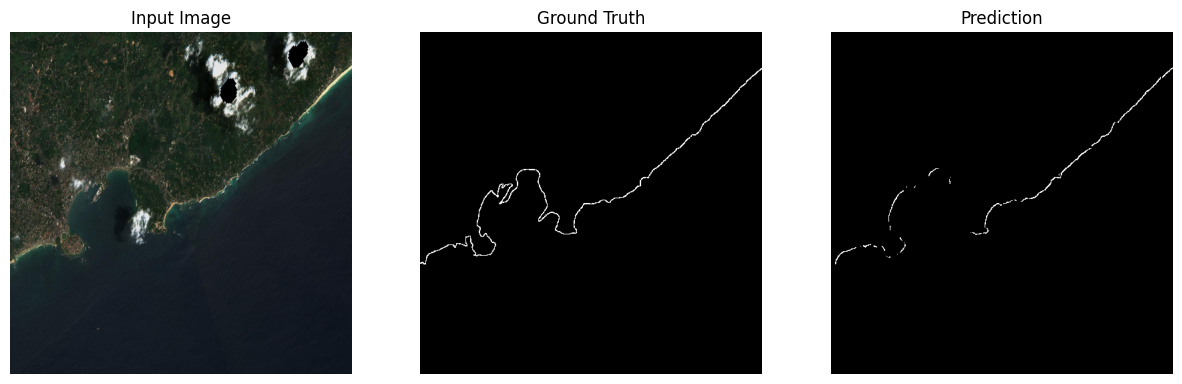

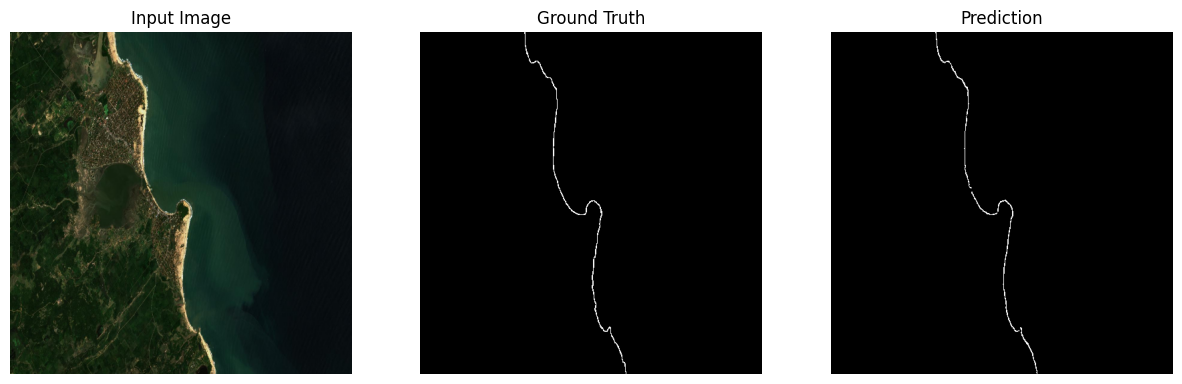

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_pred_images(image, gt_image, pred_image):
    fig = plt.figure(figsize=(15, 15))

    # Convert (3, H, W) → (H, W, 3) for RGB or (1, H, W) → (H, W) for grayscale
    image = image.cpu().numpy()
    if image.shape[0] == 3:  # If RGB, move channels last
        image = np.transpose(image, (1, 2, 0))
    else:  # If grayscale
        image = np.squeeze(image)  # Remove singleton dim

    gt_image = gt_image.cpu().numpy()
    gt_image = np.squeeze(gt_image)  # Remove singleton dim

    pred_image = np.squeeze(pred_image)  # Fix issue: Ensure proper shape

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap="gray" if len(image.shape) == 2 else None)
    plt.axis('off')
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_image, cmap="gray")
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_image, cmap="gray")
    plt.title('Prediction')
    plt.axis('off')

    plt.show()

def predict_img(net, full_img, ground_truth, device):
    net.eval()

    with torch.no_grad():
        full_img = full_img.to(device=device, dtype=torch.float32)

        # Forward pass
        output = net(full_img)

        # Convert model output to binary mask
        final_mask_batch = torch.argmax(output, dim=1).cpu().numpy()  # Shape: [batch_size, H, W]

        # print("Output Shape:", output.shape)  # Debugging
        # print("Output Sample:", output[0].cpu().numpy())  # Check sample predictions
        # print("Predicted Mask Sample:", final_mask_batch[0])  # Check mask values

    # Plot each image in the batch
    for img, lbl, pred in zip(full_img.cpu(), ground_truth.cpu(), final_mask_batch):
        plot_pred_images(img, lbl, pred)


# Get a batch from test_loader
inputs, classes = next(iter(test_loader))

# Run prediction and visualization
predict_img(model, inputs, classes, device)


In [ ]:
import numpy as np

train_masks = np.array(all_training_masks)  # Convert dataset masks to numpy

unique, counts = np.unique(train_masks, return_counts=True)
print("Class distribution in dataset:", dict(zip(unique, counts)))


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Load the trained model
model.load_state_dict(torch.load(f"{model_path}.pt"))
model.to(device)
model.eval()  # Set to evaluation mode

total_loss = 0
total_dice_score = 0

# Disable gradient calculation for validation
with torch.no_grad():
    with tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation", unit="batch") as pbar:
        for index, (inputs, classes) in pbar:
            # Move data to the device
            inputs = inputs.to(dtype=torch.float).to(device)
            classes_1 = classes.to(dtype=torch.long).to(device).squeeze(1)

            # Forward pass
            test_out = model(inputs)

            # One-hot encode ground truth masks
            masks_one_hot = torch.nn.functional.one_hot(classes_1, num_classes=model.out_channels).permute(0, 3, 1, 2).float()

            # Compute loss
            loss = F.binary_cross_entropy_with_logits(test_out, masks_one_hot)
            total_loss += loss.item()

            # Compute Dice score
            dice_score = multiclass_dice_coeff(test_out, masks_one_hot, reduce_batch_first=False)
            total_dice_score += dice_score.item()

            # Update tqdm progress bar
            pbar.set_postfix(loss=f"{loss.item():.4f}", dice_score=f"{dice_score.item():.4f}")

# Compute average loss and Dice score for validation
avg_loss = total_loss / len(val_loader)
avg_dice_score = total_dice_score / len(val_loader)

print(f"\nValidation Results: Loss={avg_loss:.4f}, Dice Score={avg_dice_score:.4f}")
